Clustering hashtags and profiles

In [52]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('coolwarm')
%matplotlib inline

In [53]:
profile_df = pd.read_csv('Business Analytics/tagged_profiles.csv')

In [54]:
profile_df.fillna('(0,0)',inplace=True)

In [55]:
profile_df['followers'] = profile_df['followers + post_count'].apply(lambda z: float(z.split(',')[0].replace('(','')))
profile_df['post_count'] = profile_df['followers + post_count'].apply(lambda z: float(z.split(',')[1].replace(')','')))

In [56]:
profile_df.drop('followers + post_count',axis=1,inplace=True)

In [57]:
profile_df.isna().sum()

n_posts       0
profile       0
followers     0
post_count    0
dtype: int64

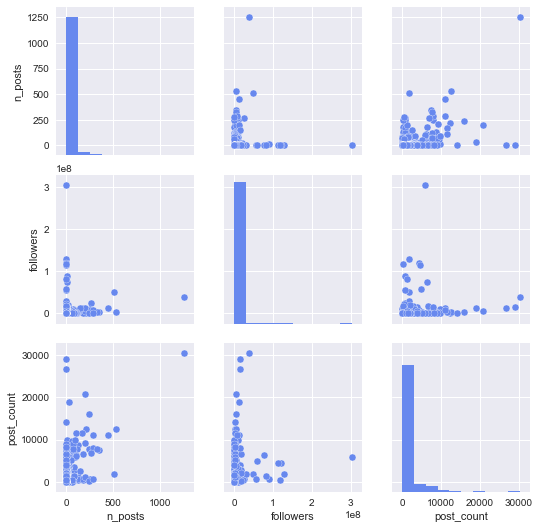

In [58]:
sns.pairplot(profile_df)

Now log transform n posts and followers, and normalize both datasets. 

In [59]:
profile_df.describe()

,n_posts,followers,post_count
count,792.000000,7.920000e+02,792.000000
mean,19.026515,2.858840e+06,1324.502525
std,67.705042,1.527562e+07,2892.968200
min,1.000000,0.000000e+00,0.000000
25%,1.000000,4.277500e+04,104.000000
50%,2.000000,1.705000e+05,366.500000
75%,8.000000,7.732500e+05,1039.000000
max,1255.000000,3.040000e+08,30420.000000


In [60]:
profile_df['followers'] = np.log10(profile_df['followers']+1)
profile_df['post_count'] = np.log10(profile_df['post_count']+1)

profile_df['n_posts'] = np.log10(profile_df['n_posts']+1)

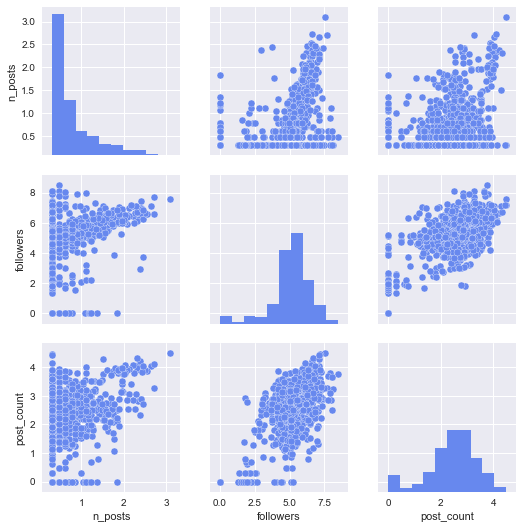

In [61]:
sns.pairplot(profile_df)

We now see a correlation between # of times a player is posted about on the nba insta, and how many followers he has. That's huge

In [62]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = profile_df.drop('profile',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


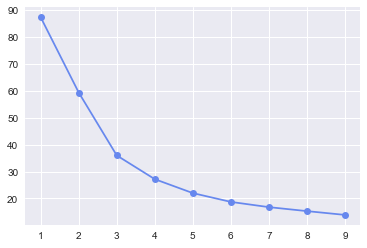

In [63]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [64]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [65]:
profile_df.dropna(subset=['followers'],inplace=True)
profile_df['Cluster'] = kmeanModel.labels_

In [66]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 792 entries, 0 to 791
Data columns (total 5 columns):
n_posts       792 non-null float64
profile       792 non-null object
followers     792 non-null float64
post_count    792 non-null float64
Cluster       792 non-null int32
dtypes: float64(3), int32(1), object(1)
memory usage: 34.0+ KB


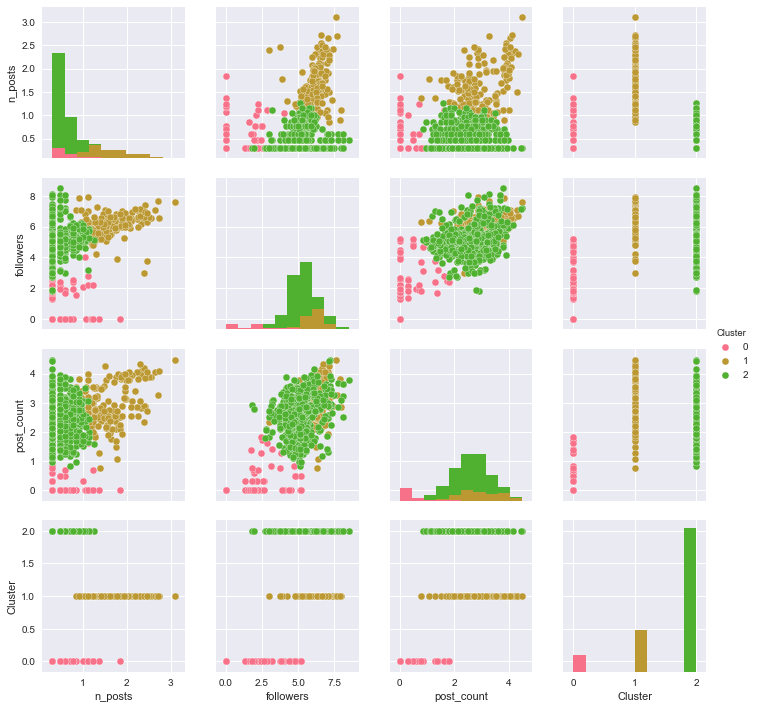

In [67]:
sns.set_palette('husl')
sns.pairplot(profile_df.drop('profile',axis=1),hue='Cluster')

In [68]:
profiles = profile_df[['profile','Cluster']].copy()
profiles = pd.get_dummies(profiles,columns=['Cluster'])

In [69]:
def apply_profile_clusters_to_training(z,profiles):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(profiles.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('@[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        try:
            post_clusters = post_clusters + profiles[profiles['profile'] == tag_in_z].values[0][1:] 
        except: 
            pass
    return post_clusters

In [70]:
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)
instas['Clusters'] = instas['Description'].str.lower().apply(lambda z: apply_profile_clusters_to_training(z,profiles))
clusters = pd.DataFrame(instas.Clusters.tolist(), columns=['profiles_nC1', 'profiles_nC2','profiles_nC3'])

In [71]:
instas.head()

,Engagements,Followers at Posting,Created,Type,Description,Clusters
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,"[0.0, 2.0, 2.0]"
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,"[0.0, 2.0, 0.0]"
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,"[0.0, 1.0, 1.0]"
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,"[0.0, 0.0, 0.0]"
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,"[0.0, 1.0, 0.0]"


In [72]:
instas = instas.merge(clusters,left_index=True,right_index=True).drop('Clusters',axis=1)

Now do the same for hashtags

In [73]:
hashtag_df = pd.read_csv('Business Analytics/used_hashtags.csv')

In [74]:
#hashtag_df.drop(columns=['max_eng','min_eng'],inplace=True)

hashtag_df = hashtag_df[['hashtags','n_posts','# of posts']]

In [75]:
hashtag_df.head()

,hashtags,n_posts,# of posts
0,#nbafinals,157,1662807.0
1,#gatoradezero,1,870.0
2,#nbaplayoffs,590,1500448.0
3,#tripledoublealert,111,2898.0
4,#powerbeatspro,2,1674.0


In [76]:
hashtag_df.isna().sum()

hashtags      0
n_posts       0
# of posts    0
dtype: int64

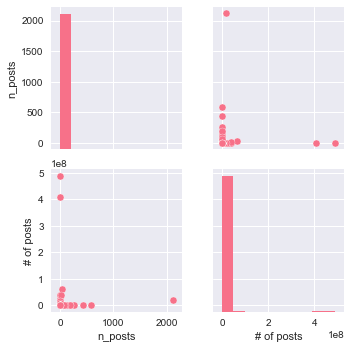

In [77]:
sns.pairplot(hashtag_df)

In [78]:
hashtag_df['# of posts'] = np.log10(hashtag_df['# of posts'] + 1)
hashtag_df['n_posts'] = np.log10(hashtag_df['n_posts'])

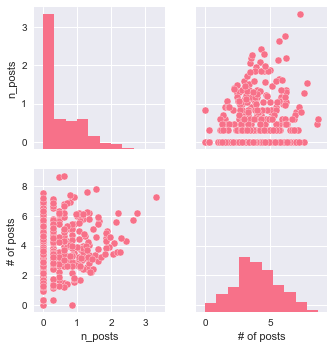

In [79]:
sns.pairplot(hashtag_df)

In [80]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = hashtag_df.drop('hashtags',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


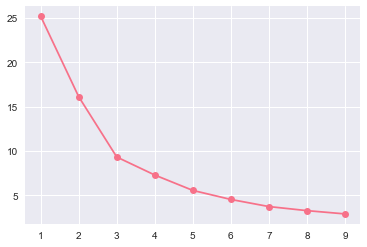

In [81]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

plt.plot(K,distortions,'o-')

In [82]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [83]:
hashtag_df['Cluster'] = kmeanModel.labels_

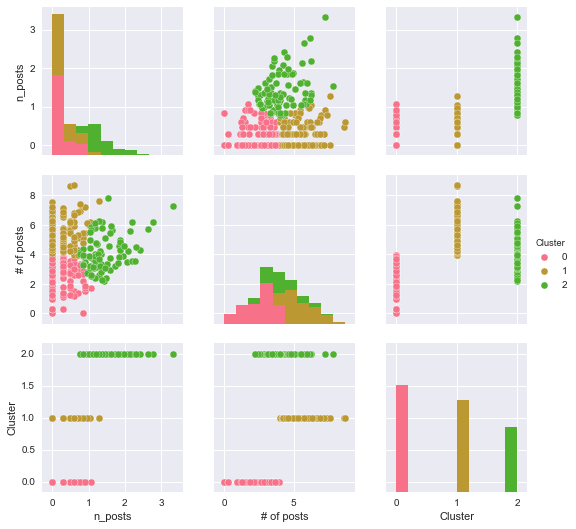

In [84]:
sns.pairplot(hashtag_df,hue='Cluster')

In [85]:
hashtags = hashtag_df[['hashtags','Cluster']].copy()
hashtags = pd.get_dummies(hashtags,columns=['Cluster'])

In [86]:
def apply_hashtag_clusters_to_training(z,hashtags):
    """Apply the clusters to the dataset, now in a form for prediction aligned with the other data. 
   
   """
    
    import re
    from numpy import zeros
    post_clusters = zeros(hashtags.shape[1] - 1)
    tags_in_z =  list( dict.fromkeys(re.findall('#[a-z_0-9]*',z)) ) 
    
    if len(tags_in_z) == 0:
        return post_clusters
    for tag_in_z in tags_in_z:
        #try:
        post_clusters = post_clusters + hashtags[hashtags['hashtags'] == tag_in_z].values[0][-(hashtags.shape[1] - 1):] 
       # except: 
       #     pass
    return post_clusters

In [87]:
hashtags.shape[1] -1

3

In [88]:
instas['HashtagClusters'] = instas['Description'].str.lower().apply(lambda z: apply_hashtag_clusters_to_training(z,hashtags))


In [89]:
clusters = pd.DataFrame(instas.HashtagClusters.tolist(), columns=['hashtags_nC1', 'hashtags_nC2','hashtags_nC3'])

In [90]:
instas = instas.merge(clusters,left_index=True,right_index=True).drop('HashtagClusters',axis=1)

#instas = instas.merge(clusters,left_index=True,right_index=True).drop('HashtagClusters',axis=1)
instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.fillna('',inplace=True)

In [91]:
instas.columns

Index(['Engagements', 'Followers at Posting', 'Created', 'Type', 'Description',
       'profiles_nC1', 'profiles_nC2', 'profiles_nC3', 'hashtags_nC1',
       'hashtags_nC2', 'hashtags_nC3'],
      dtype='object')

In [92]:
instas['Description_Len'] = instas['Description'].apply(len)
instas['num@s'] = instas['Description'].apply(lambda z: z.count('@'))
instas['num#s'] = instas['Description'].apply(lambda z: z.count('#'))
instas['num?s'] = instas['Description'].apply(lambda z: z.count('?')) # a shitty proxy for emojis
import re
instas['numCAPs'] = instas['Description'].apply(lambda z: len(re.findall(r'[A-Z]',z)))

def find_dunks(z):
    dunk_words = ['slam','jam','finish','dunk','putback','rim','windmill','flush','oop']
    for dw in dunk_words:
        if dw in z.lower(): 
            return 1
    return 0

def find_buzzer_beaters(z):
    buzzer_beater_words = ['buzz','beat','clock','winner']
    
    for bbw in buzzer_beater_words:
        if bbw in z.lower():
            return 1

In [93]:
try:
    instas.drop('HashtagClusters',axis=1,inplace=True)
except:
    pass

# Modeling time!

In [94]:
import datetime


In [95]:
instas['Timezone'] = instas['Created'].str.split(' ',expand =True)[2]
instas['Date'] = instas['Created'].str.split(' ',expand = True)[0]
instas['Month'] = instas['Date'].str.split('-',expand = True)[1]

instas['Time'] = instas['Created'].str.split(' ',expand = True)[1]
instas['Hour'] = instas['Time'].str.split(':',expand=True)[0]

instas['Date'] = pd.to_datetime(instas['Date']).astype(datetime.datetime)

instas['Weekday'] = instas['Date'].apply(lambda z: z.weekday())
instas['Year'] = instas['Created'].apply(lambda z: z.split('-')[0])

In [96]:
instas['Description'].sample(n=5).values

array(['@dmillerky from WAAAY out to beat the first half ??',
       '@kevindurant buries the late triple for the @warriors! #NBAFinals',
       '@vicoladipo would not be denied in Game 6! #PhantomCam',
       '@timmyjr10 gets on the board for the @dallasmavs with the oop!',
       'Join the NBA, @nbaontnt, & #OneAmericaAppeal in supporting disaster relief! \nBid on Opening Night game-worn jerseys! auctions.nba.com'],
      dtype=object)

In [97]:
instas.drop(columns=['Date','Time'],inplace=True)

In [98]:
instas.describe()

,Engagements,Followers at Posting,profiles_nC1,profiles_nC2,profiles_nC3,hashtags_nC1,hashtags_nC2,hashtags_nC3,Description_Len,num@s,num#s,num?s,numCAPs,Weekday
count,7.766000e+03,7.766000e+03,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000,7766.000000
mean,5.923129e+05,3.042770e+07,0.035668,1.292429,0.174221,0.038372,0.037342,0.522663,69.053953,1.509014,0.599536,1.019057,5.626835,3.081767
std,1.792682e+05,3.748957e+06,0.189594,1.079749,0.449265,0.199344,0.196941,0.661080,37.143360,1.124158,0.716520,2.521439,6.012271,1.970062
min,1.278160e+05,2.487554e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.173900e+05,2.698910e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,6.397285e+05,3.004747e+07,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1.000000,0.000000,0.000000,4.000000,3.000000
75%,7.216282e+05,3.392854e+07,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,88.000000,2.000000,1.000000,1.000000,8.000000,5.000000
max,1.129585e+06,3.698468e+07,2.000000,7.000000,7.000000,2.000000,2.000000,5.000000,639.000000,10.000000,5.000000,34.000000,54.000000,6.000000


In [99]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [100]:
X = instas.drop(columns=['Engagements','Description','Created','Followers at Posting']).copy()



In [101]:
X = pd.get_dummies(X)

In [102]:
X_norm  = normalize(X)

In [103]:
y = instas['Engagements']

In [104]:
from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import GradientBoostingRegressor

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [105]:
import xgboost as xgb

In [106]:
model = xgb.XGBRegressor()

In [107]:
#model = RandomForestRegressor(n_estimators=25)
from random import choice

In [110]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25)

model = xgb.XGBRegressor(n_estimators=550,booster='dart')#choice(models)

print("Model used: ", model)
model.fit(X_train,y_train)
print("Training score: ", model.score(X_train,y_train))
print("Original Score", model.score(X_test,y_test))

def mean_absolute_percentage_error(y_true, y_pred):
    import numpy as np
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_true = y_test
y_pred = model.predict(X_test)

#y_pred = np.array([round(y) for y in y_pred])

def MAPE_np(y_true,y_pred):
    n = y_true.shape[0]
    return 100*np.sum(np.abs(y_true-y_pred)/y_true)/n

print("MAPE Original Score ", mean_absolute_percentage_error(y_true, y_pred))


print("Jordan's MAPE, ",  MAPE_np(y_true,y_pred))

Model used:  XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=550,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
Training score:  0.9126722465599182
Original Score 0.8942162644076984
MAPE Original Score  6.833731157398179
Jordan's MAPE,  6.833731157398178


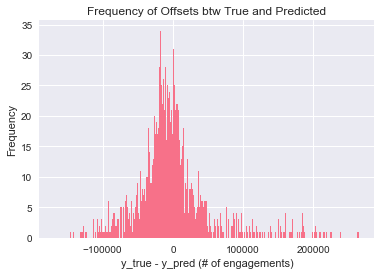

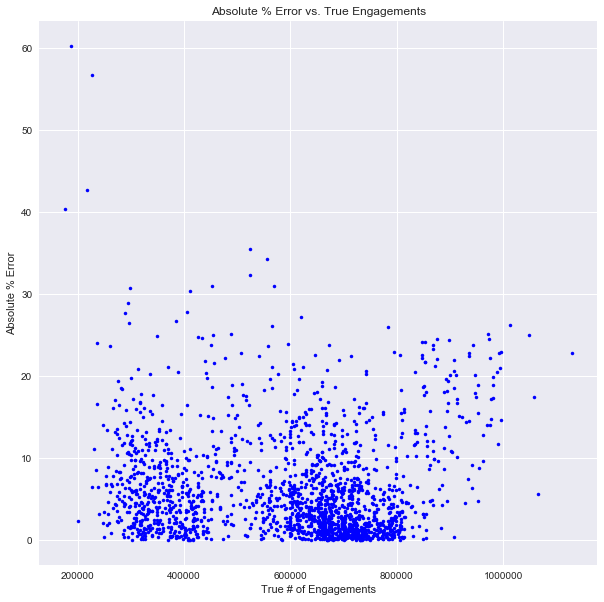

In [116]:
#what regression points are having the most trouble?
plt.title("Frequency of Offsets btw True and Predicted")
plt.hist(y_true.values - y_pred,bins=500)
plt.xlabel("y_true - y_pred (# of engagements)")
plt.ylabel("Frequency")
plt.figure(figsize=(10,10))
plt.plot(y_true.values,100*abs(y_true.values - y_pred)/ y_true.values,'b.')
plt.title("Absolute % Error vs. True Engagements")
plt.xlabel('True # of Engagements')
plt.ylabel('Absolute % Error')

So the worst guesses are occuring for the most viral posts. Let's see if there's anything we can do to fix that. 

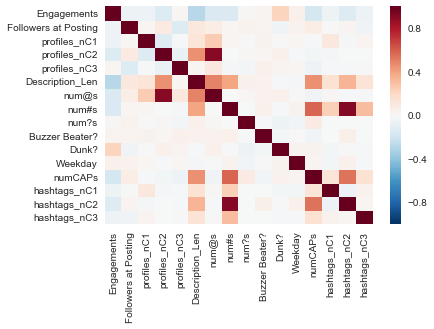

In [117]:
sns.heatmap(instas.corr())

Feature ranking:
1. feature 16 (0.746076)
Type_Video
2. feature 4 (0.048035)
num@s
3. feature 1 (0.022310)
profiles_nC2
4. feature 25 (0.019397)
Month_07
5. feature 8 (0.016288)
Dunk?
6. feature 3 (0.013092)
Description_Len
7. feature 9 (0.012808)
Weekday
8. feature 6 (0.011464)
num?s
9. feature 10 (0.010247)
numCAPs
10. feature 23 (0.004581)
Month_05
11. feature 12 (0.004380)
hashtags_nC2
12. feature 28 (0.004314)
Month_10
13. feature 56 (0.004174)
Year_2018
14. feature 5 (0.003996)
num#s
15. feature 0 (0.003924)
profiles_nC1
16. feature 52 (0.003771)
Hour_21
17. feature 27 (0.003664)
Month_09
18. feature 26 (0.003589)
Month_08
19. feature 20 (0.003556)
Month_02
20. feature 31 (0.003489)
Hour_00
21. feature 51 (0.003488)
Hour_20
22. feature 30 (0.003266)
Month_12
23. feature 53 (0.003008)
Hour_22
24. feature 54 (0.002900)
Hour_23
25. feature 21 (0.002843)
Month_03
26. feature 29 (0.002802)
Month_11
27. feature 32 (0.002673)
Hour_01
28. feature 49 (0.002453)
Hour_18
29. feature 50 (0.0

(-1, 58)

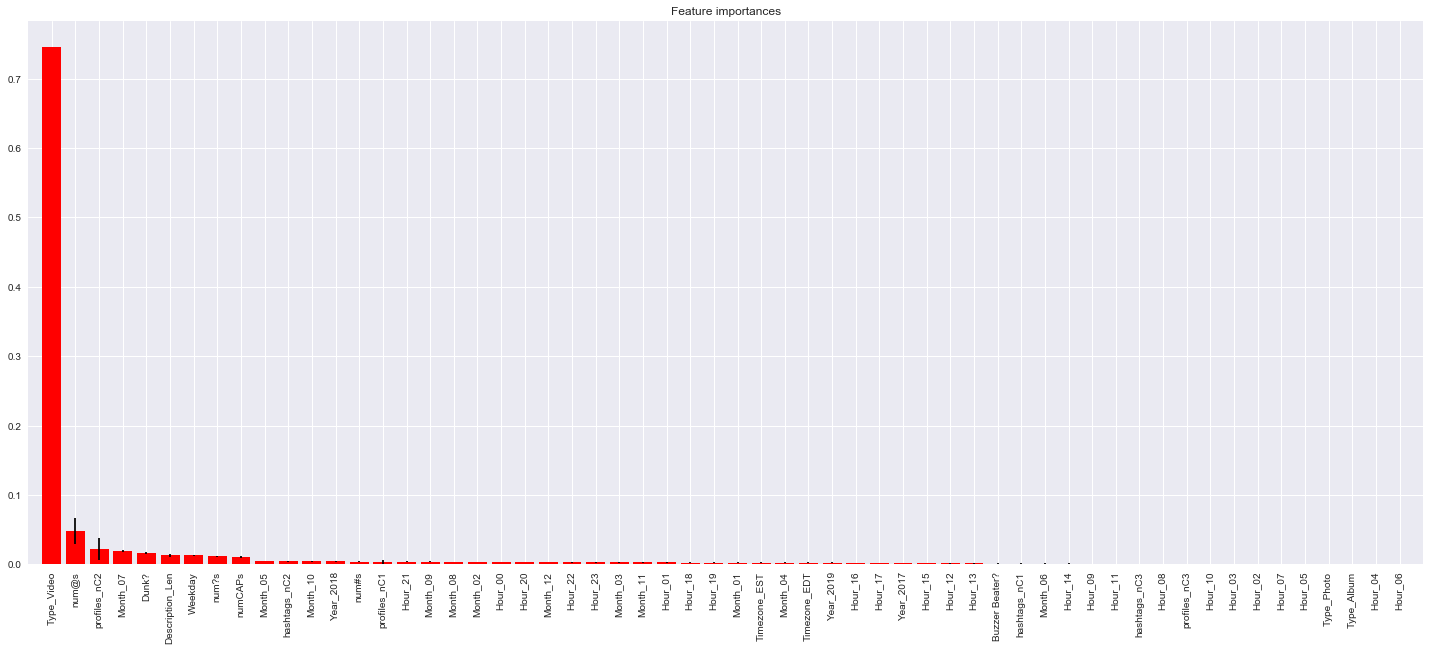

In [118]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor

# Build a classification task using 3 informative features

# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=250,
                              random_state=0)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col_names = []
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(X.columns[indices[f]])
    col_names.append(X.columns[indices[f]])

# Plot the feature importances of the forest
plt.figure(figsize=(25,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), col_names,rotation=90)
plt.xlim([-1, X.shape[1]])


In [119]:
instas

,Engagements,Followers at Posting,Created,Type,Description,profiles_nC1,profiles_nC2,profiles_nC3,Description_Len,num@s,...,Dunk?,Timezone,Month,Hour,Weekday,Year,numCAPs,hashtags_nC1,hashtags_nC2,hashtags_nC3
0,502093,36984682,2019-05-21 23:30:51 EDT,Video,The @raptors bench trio of @sergeibaka @norman...,1.0,3.0,0.0,95,4,...,0,EDT,05,23,1,2019,2,0.0,0.0,0.0
1,603380,36984682,2019-05-21 22:53:33 EDT,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.0,2.0,0.0,64,2,...,0,EDT,05,22,1,2019,3,0.0,0.0,0.0
2,603380,36984682,2019-05-21 22:19:58 EDT,Video,@k_mid22 with some english on the @bucks dime!,0.0,2.0,0.0,46,2,...,0,EDT,05,22,1,2019,0,0.0,0.0,0.0
3,725100,36984682,2019-05-21 22:02:41 EDT,Video,Kawhi punches it home with the left on TNT!,0.0,0.0,0.0,43,0,...,0,EDT,05,22,1,2019,4,0.0,0.0,0.0
4,661446,36984682,2019-05-21 20:47:49 EDT,Video,@giannis_an34 goes baseline early to rock the ...,0.0,1.0,0.0,57,1,...,1,EDT,05,20,1,2019,3,0.0,0.0,0.0
5,322444,36955156,2019-05-21 14:02:32 EDT,Photo,Congrats to the 2018-19 NBA All-Rookie First T...,0.0,2.0,0.0,104,2,...,0,EDT,05,14,1,2019,8,0.0,0.0,0.0
6,722540,36955156,2019-05-21 12:30:53 EDT,Video,The @warriors locked in for four games to adva...,0.0,1.0,0.0,106,1,...,0,EDT,05,12,1,2019,11,1.0,1.0,0.0
7,339265,36955156,2019-05-21 08:59:02 EDT,Photo,Will the @bucks take a commanding 3-1 lead... ...,0.0,2.0,0.0,88,2,...,0,EDT,05,08,1,2019,4,0.0,0.0,0.0
8,443330,36955156,2019-05-21 00:48:16 EDT,Photo,TAP to SHOP the @warriors Western Conference C...,0.0,2.0,0.0,75,2,...,0,EDT,05,00,1,2019,10,0.0,0.0,0.0
9,652193,36955156,2019-05-21 00:38:18 EDT,Video,Hey @stephencurry30... that was the first time...,0.0,2.0,0.0,121,2,...,0,EDT,05,00,1,2019,5,0.0,1.0,0.0
